In [1]:
import tensorflow as tf
from utils import bbox_utils, data_utils, drawing_utils, io_utils, train_utils, eval_utils
from models.decoder import get_decoder_model
from helper import label_generator
from models.ssd_mobilenet_v2 import get_model, init_model
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
batch_size = 8
evaluate = False
backbone = 'mobilenet_v2'
from_folder = True
hyper_params = train_utils.get_hyper_params(backbone)

In [16]:
test_tfrecord_path = r"F:\Minor Data Collection\Final Image Data\Monument Original\Merged_Original_Augmented\test_aug.tfrecord"
trained_model = "ssd_mobilenet_v2_model_weights_SSDLite.h5"
model_path = os.path.join("./Trained Models/", trained_model)
print(model_path)

./Trained Models/ssd_mobilenet_v2_model_weights_SSDLite.h5


In [3]:
image_feature_description = {
    'image/height': tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/width' : tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/filename' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/encoded' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/class/text':tf.io.FixedLenSequenceFeature(shape = (), dtype = tf.string, allow_missing = True),
    'image/object/class/label':tf.io.FixedLenSequenceFeature(shape = (), dtype = np.int64, allow_missing = True)
}

def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)

def _bytestring(parsed_example):
    byte_string = parsed_example['image/encoded']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [300, 300, 3])
    parsed_example['image/encoded'] = image
    bbox = tf.stack([parsed_example['image/object/bbox/ymin'], parsed_example['image/object/bbox/xmin'], parsed_example['image/object/bbox/ymax'], parsed_example['image/object/bbox/xmax']], axis = -1)
    output_dict = {'image': image,
                  'objects': {
                      'bbox': bbox,
                      'label':parsed_example['image/object/class/label']
                  }}

    return output_dict

def get_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(_parse_data)
    dataset = dataset.map(_bytestring)
    size_info = dataset.reduce(0, lambda x, _ : x + 1).numpy()
    return dataset, size_info

In [4]:
labels = ['bg', 'badrinath temple', 'basantapur tower', 'bhagavati temple', 'bhairavnath temple', 'bhaktapur tower', 'bhimeleshvara', 'bhimsen temple', 'bhupatindra malla column', 'bhuvana lakshmeshvara', 'chasin dega', 'chayasilin mandap', 'dattatreya temple', 'degu tale temple_KDS', 'fasidega temple', 'gaddi durbar', 'garud', 'golden gate', 'gopinath krishna temple', 'hanuman idol', 'indrapura', 'jagannatha temple', 'kala-bhairava', 'kasthamandap', 'kavindrapura sattal', 'kedamatha tirtha', 'kirtipur tower', 'kumari ghar', 'lalitpur tower', 'mahadev temple', 'narayan temple', 'national gallery', 'nyatapola temple', 'palace of the 55 windows', 'panchamukhi hanuman', 'pratap malla column', 'shiva temple', 'shveta bhairava', 'siddhi lakshmi temple', 'simha sattal', 'taleju bell_BDS', 'taleju bell_KDS', 'taleju temple', 'trailokya mohan', 'vastala temple', 'vishnu temple']
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]

In [5]:
data_types = data_utils.get_data_types()
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()

In [17]:
if from_folder:
    img_paths = data_utils.get_custom_imgs('./Assets/Test Images')
    total_items = len(img_paths)
    test_data = tf.data.Dataset.from_generator(lambda: data_utils.custom_data_generator(
                                           img_paths, img_size, img_size), data_types, data_shapes)
else:
    test_data, size_info = get_dataset(test_tfrecord_path)
    total_items = size_info
    test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))
    
test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

### Loading model

In [18]:
ssd_model = get_model(hyper_params)
ssd_model_path = io_utils.get_model_path(backbone)
ssd_model.load_weights(model_path)
prior_boxes = bbox_utils.generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])
ssd_decoder_model = get_decoder_model(ssd_model, prior_boxes, hyper_params)

In [19]:
step_size = train_utils.get_step_size(total_items, batch_size)
pred_bboxes, pred_labels, pred_scores = ssd_decoder_model.predict(test_data, steps=step_size, verbose=1)

1/1 [==============================] - 1s 1s/step


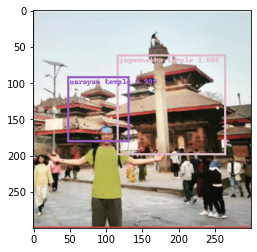

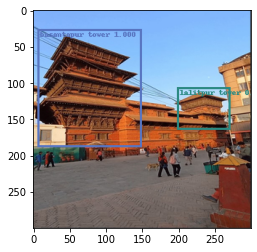

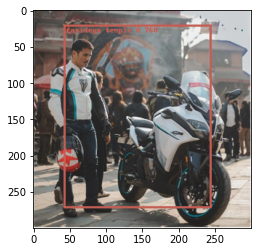

In [20]:
drawing_utils.draw_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)

In [20]:
# eval_utils.evaluate_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)

In [10]:
test_data = tf.data.Dataset.from_generator(lambda: data_utils.custom_data_generator(
                                           img_paths, img_size, img_size), data_types, data_shapes)

## Drawing bounding boxes on single image

In [29]:
plt.figure(figsize = (8, 12), dpi = 120)
box_1 = pred_bboxes[0][0]
box_2 = pred_bboxes[0][1]

score_1 = pred_scores[0][0]
score_2 = pred_scores[0][1]

label_1 = pred_labels[0][0]
label_2 = pred_labels[0][1]

for ele in test_data.as_numpy_iterator():
    img_array = np.uint8(ele[0] * 255)
    break
# print(img_array)
from PIL import Image

img = Image.open('./Assets/Test Images/inference.jpg')

width, height = img.size
print(width, height)

bbox = box_1

y1 = int(bbox[0] * height)
x1 = int(bbox[1] * width)
y2 = int(bbox[2] * height)
x2 = int(bbox[3] * width)

img = np.array(img)
cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), thickness = 2)
predicted_label = labels[int(label_1)]
(text_width, text_height), baseline = cv2.getTextSize(predicted_label, 0, 0.35, 1)
cv2.rectangle(img, (x1, y1 - 20), (x2, y1), (255, 255, 255), thickness = -1)
cv2.putText(img, predicted_label, (x1, y1 - 5), 0, 0.56, (255, 0, 0), 1, cv2.LINE_8)

bbox = box_2
y1 = int(bbox[0] * height)
x1 = int(bbox[1] * width)
y2 = int(bbox[2] * height)
x2 = int(bbox[3] * width)

cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), thickness = 2)
predicted_label = labels[int(label_2)]
(text_width, text_height), baseline = cv2.getTextSize(predicted_label, 0, 0.35, 1)
cv2.rectangle(img, (x1, y1 - 20), (x2, y1), (255, 255, 255), thickness = -1)
cv2.putText(img, predicted_label, (x1, y1 - 5), 0, 0.56, (0, 0, 255), 1, cv2.LINE_8)

# plt.imshow(img)
# plt.axis('off')
# plt.savefig('./Inferenced Images/something.jpg', bbox_inches = 'tight')


print(box_1)
print(box_2)

for i in range(1):
    print(pred_scores[0][i])
#     print(y1, x1, y2, x2)
            
# Bounding box rect
# cv2.rectangle(img_array, (x1, y1), (x2, y2), (255, 255, 31), thickness = 1)
# predicted_label = str(labels[int(pred_class_labels[count])])



519 691
[0.08783033 0.02011214 0.6281347  0.4980812 ]
[0.35325128 0.65835017 0.5465299  0.90197384]
0.9999994


<Figure size 960x1440 with 0 Axes>

In [15]:
outer_count = 69
plt.figure(figsize = (8, 6), dpi = 120)
for index, ele in enumerate(test_data):
    #loading an image
    img_array = np.uint8(ele[0].numpy())
    
    bounding_boxes = ele[1].numpy()
    class_labels = ele[2].numpy()
    print(bounding_boxes)
    break
    for count, bbox in enumerate(bounding_boxes):
        y1 = int(bbox[0] * 300)
        x1 = int(bbox[1] * 300)
        y2 = int(bbox[2] * 300)
        x2 = int(bbox[3] * 300)
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (255, 0, 0), thickness = 2)
#         cv2.putText(img_array, str(labels[class_labels[count]]), (x1, y1), 1, 1, (0, 0, 0), 1, cv2.LINE_AA)
    
    pred_class_labels = pred_labels[index]
    
    for count, bbox in enumerate(pred_bboxes[index]):
        if bbox[0] > 0 or bbox[1] > 0:
            y1 = int(bbox[0] * 300)
            x1 = int(bbox[1] * 300)
            y2 = int(bbox[2] * 300)
            x2 = int(bbox[3] * 300)
            
            # Bounding box rect
            cv2.rectangle(img_array, (x1, y1), (x2, y2), (255, 255, 31), thickness = 1)
            
            predicted_label = str(labels[int(pred_class_labels[count])])
            
            # textual rectangle
            (text_width, text_height), baseline = cv2.getTextSize(predicted_label, 0, 0.35, 1)
            print(text_width, text_height)
            
            rect_x1 = x1
            rect_y1 = y1 - 15
            rect_x2 = x1 + text_width
            rect_y2 = y1 + 2
            
            if rect_x2 > 300: 
                rect_x1 -= (rect_x2 - 300)
            if rect_y1 < 0:
                corr_factor = 15 - rect_y1
                rect_y1 += corr_factor
                rect_y2 += corr_factor
                y1 += corr_factor
            cv2.rectangle(img_array, (rect_x1, rect_y1), (rect_x2, rect_y2), (0, 0, 0), thickness = -1)
            cv2.putText(img_array, predicted_label, (rect_x1, y1), 0, 0.35, (255, 255, 255), 1, cv2.LINE_8)
        else:
            break
    
    plt.figure(figsize = (10, 10))
    plt.imshow(img_array)
    plt.axis('off')
    save_loc = f'./Inferenced Images/{outer_count}.jpg' 
    plt.savefig(save_loc, dpi = 120, bbox_inches = 'tight', pad_inches = 0.05)
    
    plt.show()
    outer_count += 1
    if outer_count == 300:
        break

[]


<Figure size 960x720 with 0 Axes>

## Drawing bounding boxes (Actual and Inferenced)

In [11]:
test_data, size_info = get_dataset(r"F:\Minor Data Collection\Final Image Data\Monument Original\Merged_Original_Augmented\test_aug.tfrecord")

In [17]:
for ele in test_data.as_numpy_iterator():
    print(ele)
    break

{'image': array([[[187, 215, 236],
        [187, 215, 236],
        [187, 215, 236],
        ...,
        [185, 212, 231],
        [185, 212, 231],
        [185, 212, 231]],

       [[186, 214, 235],
        [187, 215, 236],
        [188, 216, 237],
        ...,
        [186, 213, 232],
        [186, 213, 232],
        [186, 213, 232]],

       [[186, 214, 235],
        [187, 215, 236],
        [188, 216, 237],
        ...,
        [186, 213, 232],
        [186, 213, 232],
        [185, 212, 231]],

       ...,

       [[ 44,  45,  39],
        [ 53,  54,  46],
        [ 51,  53,  42],
        ...,
        [ 68,  54,  27],
        [150, 129,  82],
        [159, 137,  79]],

       [[ 34,  35,  29],
        [ 52,  53,  45],
        [ 58,  60,  49],
        ...,
        [ 55,  43,  17],
        [141, 123,  75],
        [157, 136,  79]],

       [[ 29,  30,  24],
        [ 53,  54,  46],
        [ 63,  64,  56],
        ...,
        [ 41,  29,   3],
        [129, 111,  65],
        [144, 

In [23]:


# outer_count = 0
# plt.figure(figsize = (8, 6), dpi = 120)
# for index, ele in enumerate(test_data):
#     #loading an image
#     img_array = np.uint8(ele['image'].numpy())
    
#     bounding_boxes = ele['objects']['bbox'].numpy()
#     class_labels = ele['objects']['label'].numpy()
    
#     for count, bbox in enumerate(bounding_boxes):
#         y1 = int(bbox[0] * 300)
#         x1 = int(bbox[1] * 300)
#         y2 = int(bbox[2] * 300)
#         x2 = int(bbox[3] * 300)
#         cv2.rectangle(img_array, (x1, y1), (x2, y2), (255, 0, 0), thickness = 2)
# #         cv2.putText(img_array, str(labels[class_labels[count]]), (x1, y1), 1, 1, (0, 0, 0), 1, cv2.LINE_AA)
    
#     pred_class_labels = pred_labels[index]
    
#     for count, bbox in enumerate(pred_bboxes[index]):
#         if bbox[0] > 0 or bbox[1] > 0:
#             y1 = int(bbox[0] * 300)
#             x1 = int(bbox[1] * 300)
#             y2 = int(bbox[2] * 300)
#             x2 = int(bbox[3] * 300)
            
#             # Bounding box rect
#             cv2.rectangle(img_array, (x1, y1), (x2, y2), (255, 255, 31), thickness = 1)
            
#             predicted_label = str(labels[int(pred_class_labels[count])])
            
#             # textual rectangle
#             (text_width, text_height), baseline = cv2.getTextSize(predicted_label, 0, 0.35, 1)
#             print(text_width, text_height)
            
#             rect_x1 = x1
#             rect_y1 = y1 - 15
#             rect_x2 = x1 + text_width
#             rect_y2 = y1 + 2
            
#             if rect_x2 > 300: 
#                 rect_x1 -= (rect_x2 - 300)
#             if rect_y1 < 0:
#                 corr_factor = 15 - rect_y1
#                 rect_y1 += corr_factor
#                 rect_y2 += corr_factor
#                 y1 += corr_factor
#             cv2.rectangle(img_array, (rect_x1, rect_y1), (rect_x2, rect_y2), (0, 0, 0), thickness = -1)
#             cv2.putText(img_array, predicted_label, (rect_x1, y1), 0, 0.35, (255, 255, 255), 1, cv2.LINE_8)
#         else:
#             break
    
#     plt.figure(figsize = (10, 10))
#     plt.imshow(img_array)
#     plt.axis('off')
# #     save_loc = f'./Inferenced Images/{outer_count}.jpg' 
# #     plt.savefig(save_loc, dpi = 120, bbox_inches = 'tight', pad_inches = 0.05)
    
#     plt.show()
#     outer_count += 1
#     if outer_count == 300:
#         break